In [ ]:
#default_exp data.core

In [ ]:
#export
from local.imports import *
from local.test import *
from local.core import *
from local.data.pipeline import *
from local.data.external import *
from local.notebook.showdoc import show_doc

In [ ]:
# Not exported since we only use it for examples
from PIL import Image

# Helper functions for processing data

> Functions for getting, splitting, and labeling data, etc

## Get, split, label, and show

For most data source creation we need functions to get a list of items, split them in to train/valid sets, and label them. fastai provides functions to make each of these steps easy (especially when combined with `fastai.data.blocks`), along with showing data (we'll only define image showing in this section).

### Get

First we'll look at functions that *get* a list of items (generally file names).

We'll use *tiny MNIST* (a subset of MNIST with just two classes, `7`s and `3`s) for our examples/tests throughout this page.

In [ ]:
path = untar_data(URLs.MNIST_TINY)
(path/'train').ls()

[PosixPath('/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/train/7'),
 PosixPath('/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/train/3')]

In [ ]:
# export
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [ ]:
# export
def get_files(path, extensions=None, recurse=True, include=None):
    "Get all the files in `path` with optional `extensions`, optionally with `recurse`."
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            if include is not None and i==0: d[:] = [o for o in d if o in include]
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        res = _get_files(path, f, extensions)
    return L(res)

This is the most general way to grab a bunch of file names from disk. If you pass `extensions` (including the `.`) then returned file names are filtered by that list. Only those files directly in `path` are included, unless you pass `recurse`, in which case all child folders are also searched recursively. `include` is an optional list of directories to limit the search to.

In [ ]:
t3 = get_files(path/'train'/'3', extensions='.png', recurse=False)
t7 = get_files(path/'train'/'7', extensions='.png', recurse=False)
t  = get_files(path/'train', extensions='.png', recurse=True)
test_eq(len(t), len(t3)+len(t7))
test_eq(len(get_files(path/'train'/'3', extensions='.jpg', recurse=False)),0)
test_eq(len(t), len(get_files(path, extensions='.png', recurse=True, include='train')))
t

(#709) [/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/train/7/7010.png,/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/train/7/79.png,/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/train/7/9022.png,/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/train/7/7284.png,/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/train/7/7085.png,/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/train/7/7547.png,/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/train/7/8698.png,/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/train/7/8463.png,/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/train/7/7525.png,/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/train/7/8345.png...]

In [ ]:
#hide
test_eq(len(get_files(path/'train'/'3', recurse=False)),346)
test_eq(len(get_files(path, extensions='.png', recurse=True, include=['train', 'test'])),729)

It's often useful to be able to create functions with customized behavior. `fastai.data` generally uses functions named as CamelCase verbs ending in `er` to create these functions. `FileGetter` is a simple example of such a function creator.

In [ ]:
#export
def FileGetter(suf='', extensions=None, recurse=True, include=None):
    "Create `get_files` partial function that searches path suffix `suf` and passes along args"
    def _inner(o, extensions=extensions, recurse=recurse, include=include): return get_files(o/suf, extensions, recurse, include)
    return _inner

In [ ]:
fpng = FileGetter(extensions='.png', recurse=False)
test_eq(len(t7), len(fpng(path/'train'/'7')))
test_eq(len(t), len(fpng(path/'train', recurse=True)))
fpng_r = FileGetter(extensions='.png', recurse=True)
test_eq(len(t), len(fpng_r(path/'train')))

In [ ]:
#export
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [ ]:
#export
def get_image_files(path, recurse=True, include=None):
    "Get image files in `path` recursively."
    return get_files(path, extensions=image_extensions, recurse=recurse, include=include)

This is simply `get_files` called with a list of standard image extensions.

In [ ]:
test_eq(len(t), len(get_image_files(path, recurse=True, include='train')))

In [ ]:
#export
def ImageGetter(suf='', recurse=True, include=None):
    "Create `get_image_files` partial function that searches path suffix `suf` and passes along `kwargs`"
    def _inner(o, recurse=recurse, include=include): return get_image_files(o/suf, recurse, include)
    return _inner

Same as `FileGetter`, but for image extensions.

In [ ]:
test_eq(len(get_files(path/'train', extensions='.png', recurse=True, include='3')),
        len(ImageGetter(  'train',                    recurse=True, include='3')(path)))

### Split

The next set of functions are used to *split* data into training and validation sets. The functions return two lists - a list of indices or masks for each of training and validation sets.

In [ ]:
# export
def RandomSplitter(valid_pct=0.2, seed=None, **kwargs):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o, **kwargs):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = L(int(i) for i in torch.randperm(len(o)))
        cut = int(valid_pct * len(o))
        return rand_idx[cut:],rand_idx[:cut]
    return _inner

In [ ]:
src = list(range(30))
f = RandomSplitter(seed=42)
trn,val = f(src)
assert 0<len(trn)<len(src)
assert all(o not in val for o in trn)
test_eq(len(trn), len(src)-len(val))
# test random seed consistency
test_eq(f(src)[0], trn)
trn,val

((#24) [10,18,16,23,28,26,20,7,21,22...], (#6) [12,0,6,25,8,15])

In [ ]:
# export
def _grandparent_idxs(items, name): return mask2idxs(Path(o).parent.parent.name == name for o in items)

In [ ]:
# export
def GrandparentSplitter(train_name='train', valid_name='valid'):
    "Split `items` from the grand parent folder names (`train_name` and `valid_name`)."
    def _inner(o, **kwargs):
        return _grandparent_idxs(o, train_name),_grandparent_idxs(o, valid_name)
    return _inner

In [ ]:
items = [path/'train/3/9932.png', path/'valid/7/7189.png', 
         path/'valid/7/7320.png', path/'train/7/9833.png',  
         path/'train/3/7666.png', path/'valid/3/925.png',
         path/'train/7/724.png', path/'valid/3/93055.png']
splitter = GrandparentSplitter()
test_eq(splitter(items),[[0,3,4,6],[1,2,5,7]])

### Label

The final set of functions is used to *label* a single item of data.

In [ ]:
# export
def parent_label(o, **kwargs):
    "Label `item` with the parent folder name."
    return o.parent.name if isinstance(o, Path) else o.split(os.path.sep)[-1]

Note that `parent_label` doesn't have anything customize, so it doesn't return a function - you can just use it directly.

In [ ]:
test_eq(parent_label(items[0]), '3')
[parent_label(o) for o in items]

['3', '7', '7', '7', '3', '3', '7', '3']

In [ ]:
# export
def RegexLabeller(pat):
    "Label `item` with regex `pat`."
    pat = re.compile(pat)
    def _inner(o, **kwargs):
        res = pat.search(str(o))
        assert res,f'Failed to find "{pat}" in "{o}"'
        return res.group(1)
    return _inner

`RegexLabeller` is a very flexible function since it handles any regex search of the stringified item. For instance, here's an example the replicates the previous `parent_label` results.

In [ ]:
f = RegexLabeller(r'/(\d)/')
test_eq(parent_label(items[0]), '3')
[f(o) for o in items]

['3', '7', '7', '7', '3', '3', '7', '3']

### Show

In [ ]:
#export
def show_image(im, ax=None, figsize=None, title=None, ctx=None, **kwargs):
    "Show a PIL image on `ax`."
    ax = ifnone(ax,ctx)
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    # Handle pytorch axis order
    if isinstance(im,Tensor) and im.shape[0]<5: im=im.permute(1,2,0)
    # Handle 1-channel images
    if im.shape[-1]==1: im=im[...,0]
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.axis('off')
    return ax

`show_image` can show b&w images...

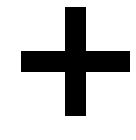

In [ ]:
im = make_cross_image()
ax = show_image(im, cmap="Greys", figsize=(2,2))

...and color images with standard `c*h*w` dim order...

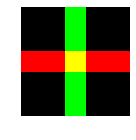

In [ ]:
im2 = make_cross_image(False)
ax = show_image(im2, figsize=(2,2))

...and color images with `h*w*c` dim order...

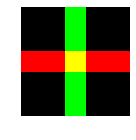

In [ ]:
im3 = im2.permute(1,2,0)
ax = show_image(im3, figsize=(2,2))

In [ ]:
#export
def show_title(o, ax=None):
    "Set title of `ax` to `o`, or print `o` if `ax` is `None`"
    if ax is None: print(o)
    else: ax.set_title(o)

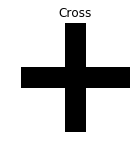

In [ ]:
ax = show_image(im, cmap="Greys", figsize=(2,2))
show_title("Cross", ax)

In [ ]:
#export
def show_titled_image(o,ax):
    "Call `show_image` destructuring `o` to `(img,title)`"
    show_image(o[0], ax, title=o[1])

In [ ]:
#export
def show_image_batch(b, show=show_titled_image, items=9, cols=3, figsize=None, **kwargs):
    "Display batch `b` in a grid of size `items` with `cols` width"
    rows = (items+cols-1) // cols
    if figsize is None: figsize = (cols*3, rows*3)
    fig,axs = plt.subplots(rows, cols, figsize=figsize)
    for *o,ax in zip(*b, axs.flatten()): show(o, ax=ax, **kwargs)

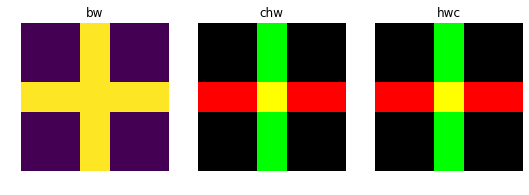

In [ ]:
show_image_batch(([im,im2,im3],['bw','chw','hwc']), items=3)

## Categorize -

In [ ]:
# export
class Categorize(Transform):
    "Reversible transform of category string to `vocab` id"
    _order=1
    def __init__(self, vocab=None, train_attr="train"):
        self.vocab,self.train_attr = vocab,train_attr
        self.o2i = None if vocab is None else {v:k for k,v in enumerate(vocab)}
        
    def setup(self, dsrc):
        if self.vocab is not None: return
        if self.train_attr: dsrc = getattr(dsrc,self.train_attr)
        self.vocab,self.o2i = uniqueify(dsrc, sort=True, bidir=True)

    def encodes(self, o): return self.o2i[o] if self.o2i else o
    def decodes(self, o):  return self.vocab[o]
    def shows(self, o, ctx=None): show_title(o, ax=ctx)

### End-to-end dataset example with MNIST

In [ ]:
items = get_image_files(path)
splits = splitter(items)
train,valid = (items[i] for i in splits)
train,valid

((#709) [/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/train/7/7010.png,/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/train/7/79.png,/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/train/7/9022.png,/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/train/7/7284.png,/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/train/7/7085.png,/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/train/7/7547.png,/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/train/7/8698.png,/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/train/7/8463.png,/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/train/7/7525.png,/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/train/7/8345.png...],
 (#699) [/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/valid/7/9968.png,/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/valid/7/79.png,/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/valid/7/8356.png,/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/valid/7/9909.png,/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/valid/7/

In [ ]:
timg = Transform(Image.open, shows=partial(show_image, cmap="Greys"))
tfms = [[timg,compose(array, torch.FloatTensor, partial(torch.unsqueeze,dim=0))],
        [parent_label, Categorize(train_attr=None)]]
train_ds,valid_ds = map(partial(Pipelines.create, tfms=tfms), (train,valid))

TypeError: Invalid dimensions for image data

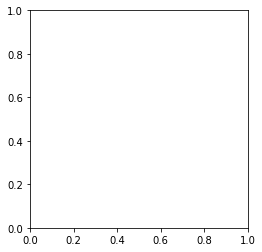

In [ ]:
train_ds.show_at(0)

In [ ]:
%debug

> /home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/image.py(646)set_data()
    644         if not (self._A.ndim == 2
    645                 or self._A.ndim == 3 and self._A.shape[-1] in [3, 4]):
--> 646             raise TypeError("Invalid dimensions for image data")
    647 
    648         if self._A.ndim == 3:

ipdb> u
> /home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py(5494)imshow()
   5492                               resample=resample, **kwargs)
   5493 
-> 5494         im.set_data(X)
   5495         im.set_alpha(alpha)
   5496         if im.get_clip_path() is None:

ipdb> u
> /home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py(1810)inner()
   1808                         "the Matplotlib list!)" % (label_namer, func.__name__),
   1809                         RuntimeWarning, stacklevel=2)
-> 1810             return func(ax, *args, **kwargs)
   1811 
   1812         inner.__doc__ = _add_data_doc(inner.__doc__,

ipdb> u


## TfmDataLoader -

In [ ]:
#export
def _DataLoader__getattr(self,k):
    try: return getattr(self.dataset, k)
    except AttributeError: raise AttributeError(k) from None
DataLoader.__getattr__ = _DataLoader__getattr

In [ ]:
#export
@docs
class TfmDataLoader(GetAttr):
    "Transformed `DataLoader` using a `Pipeline` of `tfms`"
    _xtra = 'batch_size num_workers dataset sampler pin_memory'.split()
    
    def __init__(self, dl, tfms=None, **kwargs):
        self.dl,self.tfm = dl,Pipeline(tfms)
        self.tfm.setup(self)
        self.default = self.dl # for `GetAttr`
        for k,v in kwargs.items(): setattr(self,k,v)
    
    def __len__(self): return len(self.dl)
    def __iter__(self): return map(self.tfm, self.dl)
    def one_batch(self): return next(iter(self))
    def decode(self, b): return getattr(self.dataset,'decode_batch',noop)(self.tfm.decode(b))
            
    _docs = dict(decode="Decode `b` using `ds_tfm` and `tfm`",
                 one_batch="Grab first batch of `dl`")

In [ ]:
tfms = Transform(torch.neg,decodes=torch.neg)
start = range(50)
dl = DataLoader(start, batch_size=4)
tdl = TfmDataLoader(dl, tfms)
test_eq(start, tdl.dataset)
test_eq(len(tdl), len(dl))
test_eq(tdl.batch_size, 4)

### Methods

In [ ]:
show_doc(TfmDataLoader.one_batch)

<h4 id="TfmDataLoader.one_batch" class="doc_header"><code>one_batch</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/04_data_core.ipynb#TfmDataLoader--" class="source_link" style="float:right">[source]</a></h4>

> <code>one_batch</code>()

Grab first batch of `dl`

In [ ]:
b = tdl.one_batch()
test_eq([0,-1,-2,-3], b)

In [ ]:
show_doc(TfmDataLoader.decode)

<h4 id="TfmDataLoader.decode" class="doc_header"><code>decode</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/04_data_core.ipynb#TfmDataLoader--" class="source_link" style="float:right">[source]</a></h4>

> <code>decode</code>(**`b`**)

Decode `b` using `ds_tfm` and `tfm`

## Cuda -

In [ ]:
# export
@docs
class Cuda(Transform):
    "Move batch to `device` (defaults to `defaults.device`)"
    def __init__(self,device=defaults.device): self.device=device
    def encodes(self, b): return to_device(b, self.device)
    def decodes(self, b): return to_cpu(b)
    
    _docs=dict(encodes="Move batch to `device`", decodes="Return batch to CPU")

In [ ]:
tfm = Cuda()

In [ ]:
show_doc(Cuda.encodes)

<h4 id="Cuda.encodes" class="doc_header"><code>encodes</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/04_data_core.ipynb#Cuda--" class="source_link" style="float:right">[source]</a></h4>

> <code>encodes</code>(**`b`**)

Move batch to [`device`](https://pytorch.org/docs/stable/tensor_attributes.html#torch-device)

Note that, like all `Transform`s, `encodes` is called by `tfm()` and `decodes` is called by `tfm.decode()`.

In [ ]:
t = tfm(tensor(1))
test_eq(t,1)
test_eq(t.type(),'torch.cuda.LongTensor')

In [ ]:
show_doc(Cuda.decodes)

<h4 id="Cuda.decodes" class="doc_header"><code>decodes</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/04_data_core.ipynb#Cuda--" class="source_link" style="float:right">[source]</a></h4>

> <code>decodes</code>(**`b`**)

Return batch to CPU

In [ ]:
t = tfm.decode(t)
test_eq(t,1)
test_eq(t.type(),'torch.LongTensor')

## Normalization -

In [ ]:
# export
@docs
class Normalize(Transform):
    "Normalize/denorm batch (where `fld_mask`, defaults to (True,False), is True) using `mean` and `std`"
    _order=99
    def __init__(self, mean, std, fld_mask=None):
        self.mask = ifnone(fld_mask, (True,False))
        self.mean,self.std = mean,std
    
    def _apply(self,f,b): return tuple(f(o) if p else o for o,p in zip(b,self.mask))
    def encodes(self, b): return self._apply(self._normalize,b)
    def decodes(self, b): return self._apply(self._denorm,b)
    def _normalize(self, x): return (x-self.mean) / self.std
    def _denorm(self, x):    return (x*self.std ) + self.mean
    
    _docs=dict(encodes="Normalize batch matching `fld_mask`", decodes="Denormalize batch matching `fld_mask`")

In [ ]:
def broadcast_vec(dim, ndim, *t, cuda=True):
    v = [1]*ndim
    v[dim] = -1
    f = to_device if cuda else noop
    return [f(tensor(o).view(*v)) for o in t]

In [ ]:
train_ds[0][0].std()

tensor(83.5005)

In [ ]:
mean,std = [127.5]*3,[127.5]*3
mean,std = broadcast_vec(1, 4, mean, std)

In [ ]:
dl_tfms = [Cuda(), Normalize(mean,std)]

In [ ]:
dl = DataLoader(train_ds, batch_size=4)
tdl = TfmDataLoader(dl, dl_tfms)

In [ ]:
x,y  = tdl.one_batch()
xd,yd = tdl.decode((x,y))

In [ ]:
x.type(), xd[0].type(), x.mean(), x.std(), tensor(xd).mean(), xd.std()

AttributeError: type

## DataBunch -

In [ ]:
# export
class DataBunch():
    "Basic wrapper around several `DataLoader`s."
    def __init__(self, *dls): self.dls = dls
    def __getitem__(self, i): return self.dls[i]

    train_dl,valid_dl = add_props(lambda i,x: x[i])
    train_ds,valid_ds = add_props(lambda i,x: x[i].dataset)

In [ ]:
dbch = DataBunch(dl,tdl)
test_eq([0, 1, 2, 3], next(iter(dbch.train_dl)))
test_eq([0,-1,-2,-3], dbch.valid_dl.one_batch())

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 02_data_pipeline.ipynb.
Converted 03_data_external.ipynb.
Converted 04_data_core.ipynb.
Converted 05_data_source.ipynb.
Converted 06_vision_core.ipynb.
Converted 07_pets_tutorial.ipynb.
Converted 10_layers.ipynb.
Converted 90_notebook_core.ipynb.
Converted 91_notebook_export.ipynb.
Converted 92_notebook_showdoc.ipynb.
Converted 93_notebook_export2html.ipynb.
Converted 94_index.ipynb.
